In [21]:
import base64
import datetime
import gc
import json
import pickle
import random
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import statsmodels as sm
from pylab import rcParams
from numpy import median
import matplotlib.dates as mdates

from xgboost import XGBClassifier
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(1337)
%matplotlib inline
sns.set(font_scale=1.5)
rcParams['figure.figsize'] = 8, 6
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

In [2]:
def pk(true, pred, k):
    pred = pred[:k]
    if k <= len(pred) and pred[k-1] in true:
        return 1.0 * len(set(true) & set(pred)) / len(pred)
    else:
        return 0.0
def apk(true, pred, k):
    if true == '' or pred == '':
        return 0.0
    true = true.split(' ')
    pred = pred.split(' ')
    m = len(true)
    n = len(pred)
    s = 0.0
    for i in range(1, 8):
        s += pk(true, pred, i)
    return 1.0 * s / min(m, 7)

In [3]:
def rank(s):
    return ' '.join(s.sort_values(ascending=False).index[:7])

In [4]:
products = '''ind_recibo_ult1
ind_cco_fin_ult1
ind_nom_pens_ult1
ind_nomina_ult1
ind_cno_fin_ult1
ind_tjcr_fin_ult1
ind_ecue_fin_ult1
ind_dela_fin_ult1
ind_reca_fin_ult1
ind_ctma_fin_ult1
ind_valo_fin_ult1
ind_fond_fin_ult1
ind_deco_fin_ult1
ind_ctop_fin_ult1
ind_ctpp_fin_ult1
ind_plan_fin_ult1
ind_ctju_fin_ult1
ind_deme_fin_ult1
ind_cder_fin_ult1
ind_pres_fin_ult1
ind_hip_fin_ult1
ind_viv_fin_ult1
ind_aval_fin_ult1
ind_ahor_fin_ult1'''.split('\n')

In [ ]:
for p in products:
    print p
    d = pd.read_csv('tmp/dmy_train_{0}.csv'.format(p))
    del d['customer_id']
    del d['target_name']
    l = d.target.copy()
    del d['target']
    m = XGBClassifier(
                n_estimators=100,
                learning_rate=0.01,
                max_depth=9,
                gamma=0,
                min_child_weight=1,
                #scale_pos_weight=5.0,
                nthread=2)
    m.fit(d, l)
    del d
    del l
    pickle.dump(m, open('tmp/m_xgb_ne100_{0}.pickle'.format(p), 'w'))
    del m
    gc.collect()

In [5]:
models = {}
for p in products:
    models[p] = pickle.load(open('tmp/m_xgb_ne100_{0}.pickle'.format(p), 'r'))

In [6]:
t = pd.read_csv('output/sample_submission.csv')
t = t[['ncodpers']].copy()

In [7]:
d = pd.read_csv('tmp/dmy_test.csv')
d = pd.merge(t, d, how='left', left_on='ncodpers', right_on='customer_id')
del d['customer_id']
del d['target_name']
del d['target']
del d['ncodpers']

In [8]:
s = pd.DataFrame()
sp = pd.DataFrame()
for p in products:
    print p
    s[p] = models[p].predict(d)
    sp[p] = models[p].predict_proba(d)[:,1]
del d

ind_recibo_ult1
ind_cco_fin_ult1
ind_nom_pens_ult1
ind_nomina_ult1
ind_cno_fin_ult1
ind_tjcr_fin_ult1
ind_ecue_fin_ult1
ind_dela_fin_ult1
ind_reca_fin_ult1
ind_ctma_fin_ult1
ind_valo_fin_ult1
ind_fond_fin_ult1
ind_deco_fin_ult1
ind_ctop_fin_ult1
ind_ctpp_fin_ult1
ind_plan_fin_ult1
ind_ctju_fin_ult1
ind_deme_fin_ult1
ind_cder_fin_ult1
ind_pres_fin_ult1
ind_hip_fin_ult1
ind_viv_fin_ult1
ind_aval_fin_ult1
ind_ahor_fin_ult1


In [9]:
# s.to_csv('tmp/s_xgb_ne100.csv', index=False)
# sp.to_csv('tmp/sp_xgb_ne100.csv', index=False)

In [138]:
s = pd.read_csv('tmp/s_xgb_ne100.csv', usecols=products)
sp = pd.read_csv('tmp/sp_xgb_ne100.csv', usecols=products)

In [139]:
# sp = pd.DataFrame(sklearn.preprocessing.normalize(sp, axis=0), columns=products)
# sp.head(8).T

In [140]:
#q = 10000
#pd.qcut(sp.ind_cco_fin_ult1 + np.random.randn(len(sp)) / 10000, q, labels=range(q))[:20]


In [141]:
#pd.qcut(x=sp.ind_cco_fin_ult1, q=1000, labels=range(1000))

ind_recibo_ult1


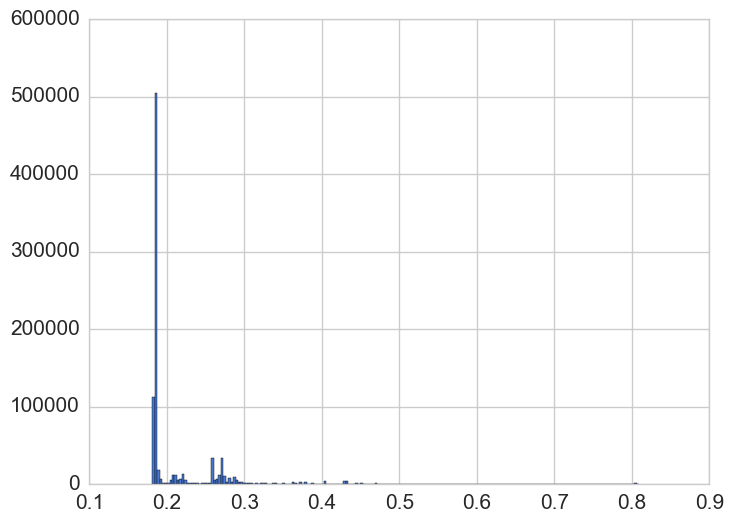

In [142]:
i = 0
print products[i]
_ = plt.hist(sp[products[i]], bins=200)
#_ = plt.xlim((0.15, 0.25))

In [143]:
for i in range(1, 26):
    print 1.0 - pow(0.6, i-1)

0.0
0.4
0.64
0.784
0.8704
0.92224
0.953344
0.9720064
0.98320384
0.989922304
0.9939533824
0.99637202944
0.997823217664
0.998693930598
0.999216358359
0.999529815015
0.999717889009
0.999830733406
0.999898440043
0.999939064026
0.999963438416
0.999978063049
0.99998683783
0.999992102698
0.999995261619


In [144]:
i = 1
q = 10000
for p in products:
    #sp[p] = sp[p] - sp[p].mean() - sp[p].quantile(pow(i / 25.0, 1.2))
    sp[p] = pd.qcut(sp[p] + np.random.randn(len(sp)) / 10000, q, labels=range(q)).astype(int) - (1.0 - pow(0.7, i-1)) * 0.2 * q
    i += 1
sp.mean().sort_values(ascending=False)

ind_recibo_ult1      4999.499999
ind_cco_fin_ult1     4399.499999
ind_nom_pens_ult1    3979.499999
ind_nomina_ult1      3685.499999
ind_cno_fin_ult1     3479.699999
ind_tjcr_fin_ult1    3335.639999
ind_ecue_fin_ult1    3234.797999
ind_dela_fin_ult1    3164.208599
ind_reca_fin_ult1    3114.796019
ind_ctma_fin_ult1    3080.207213
ind_valo_fin_ult1    3055.995049
ind_fond_fin_ult1    3039.046534
ind_deco_fin_ult1    3027.182574
ind_ctop_fin_ult1    3018.877802
ind_ctpp_fin_ult1    3013.064461
ind_plan_fin_ult1    3008.995122
ind_ctju_fin_ult1    3006.146586
ind_deme_fin_ult1    3004.152610
ind_cder_fin_ult1    3002.756827
ind_pres_fin_ult1    3001.779778
ind_hip_fin_ult1     3001.095845
ind_viv_fin_ult1     3000.617091
ind_aval_fin_ult1    3000.281964
ind_ahor_fin_ult1    3000.047374
dtype: float64

In [145]:
sp['added_products'] = sp.apply(lambda r: rank(r), axis=1)

In [146]:
for p in products:
    del sp[p]

In [147]:
sp.insert(0, 'ncodpers', t.ncodpers)
sp.to_csv('output/s9.csv', index=False)